# Parameters fitting 

In [1]:
%config InlineBackend.figure_format = "retina"

## Using pyABC

This is a simple example of how we can use a package like [pyABC](https://pyabc.readthedocs.io/) to estimate the fundamental parameters for an observed cluster. The user can combine **ASteCA** with any other package of their choosing, here's a list with many Python-based [MCMC and ABC packages](https://gabriel-p.github.io/pythonMCMC/).

We start by instantiating an `isochrones` object with a PARSEC isochrone. This is an example file but you can use whatever isochrone service fits your needs:

In [3]:
import asteca

# Load isochrones
isochs = asteca.isochrones(
    model='parsec',
    isochs_path="../_static/parsec/",
    magnitude="Gmag",
    color=("G_BPmag", "G_RPmag"),
    magnitude_effl=6390.7,
    color_effl=(5182.58, 7825.08),
    verbose=2
)


Instantiating isochrones...
Model          : PARSEC
N_files        : 1
N_met          : 3
N_age          : 11
N_isoch        : 2500
z   range      : [0.01, 0.02]
loga range     : [7.0, 9.5]
Magnitude      : Gmag
Color          : G_BPmag-G_RPmag
Isochrone object generated


Next we instantiate a `synthetic` object, passing the `isochs` object we just created (we are using all defaults for the arguments here):

In [2]:
# Synthetic clusters parameters
synthcl = asteca.synthetic(isochs, seed=457304, verbose=2)


Instantiating synthetic...
IMF            : chabrier_2014
Max init mass  : 20000
Gamma dist     : D&K
Extinction law : CCMO
Diff reddening : uniform
Random seed    : 457304
Synthetic clusters object generated


Now we load our observed cluster as a `pandas.DataFrame()` object and define a ``asteca.cluster()`` object:

In [4]:
import pandas as pd

obs_df = pd.read_csv("../_static/cluster.csv")

my_cluster = asteca.cluster(
    magnitude=obs_df["Gmag"],
    e_mag=obs_df["e_Gmag"],
    color=obs_df["BP-RP"],
    e_color=obs_df["e_BP-RP"],
    verbose=2
)


Instantiating cluster...
Columns read   : Magnitude, e_mag, Color, e_color
N_stars        : 2759
N_clust_min    : 25
N_clust_max    : 5000
Cluster object generated


We assume that the cluster file loaded in `obs_df` is composed of only the most probable members of the cluster. If not, you can use the `asteca.membership` class to first obtain the membership probabilities and then decide which stars are the most probable members.

Finally, we need to calibrate our `synthetic` object and instantiate a `likelihood` object, which will be used to quantify how similar our observed cluster is to the generated synthetic clusters. For both operations we need to pass the `my_cluster` object we generated above.

In [5]:
# Calibrate the `synthcl` object
synthcl.calibrate(my_cluster)

# Instantiate the likelihood
likelihood = asteca.likelihood(my_cluster)


Likelihood object generated


We are now ready to begin the fundamental parameters estimation process with pyABC. The first step is to import pyABC and define the priors for the parameters that are being estimated, as well as a dictionary with the remaining fundamental parameters that are *not* being estimated and are thus fixed to a certain value.

Notice that the priors defined this way for pyABC require using the minimum value and the desired *range*, not the maximum value.

In [6]:
import pyabc

met_min, met_max = 0.01, 0.02
loga_min, loga_max = 7.0, 9.5
dm_min, dm_max = 8.0, 10.5
Av_min, Av_max = 0.0, 2.0

# Define a pyABC Distribution(). Uniform distributions are employed for all the parameters
# here but the user can of course change this as desired. See the pyABC docs for more
# information.
priors = pyabc.Distribution(
    {
        "met": pyabc.RV("uniform", met_min, met_max - met_min),
        "loga": pyabc.RV("uniform", loga_min, loga_max - loga_min),
        "dm": pyabc.RV("uniform", dm_min, dm_max - dm_min),
        "Av": pyabc.RV("uniform", Av_min, Av_max - Av_min)
    }
)

This dictionary contains the fixed parameters, i.e.: those that are not being estimated and thus have fixed values:

In [7]:
# This dictionary contains the fixed values for the set of fundamental parameters
# that are *not* being estimated via pyABC
fixed_params = {"alpha": 0.1, "beta": 1.0, "Rv": 3.1, "met": 0.0152, "DR": 0.0}

pyABC works by minimizing the distance between our data (the observed cluster) and synthetic data (the synthetic clusters). We will need two convenience functions to do this.

The first function required is `model()` which takes a dictionary with the fundamental parameters being estimated by pyABC and combines it with the ones that are not. After that it generates a synthetic cluster via the `generate()` method and returns it as a dictionary. The returned variable is a dictionary simply because this is what pyABC expects; this is not a requirement of **ASteCA**.

In [8]:
def model(fit_params):
    """
    This function generates a synthetic cluster combining the
    fixed parameters in `fixed_params` with the parameters selected
    by pyABC in `fit_params`.
    """
    # Combine `fixed_params` dictionary with parameter values in `fit_params`
    # to generate a single dictionary with all the required fundamental
    # parameters
    synth_params = fixed_params | dict(fit_params)

    # Generate synthetic array
    synth_arr = synthcl.generate(synth_params)

    # pyABC expects a dictionary from this function, so we return a
    # dictionary with a single element.
    synth_dict = {"data": synth_arr}

    return synth_dict

We then define a `distance()` function that returns the likelihood `lkl` between the observed and synthetic data, via the `likelihood` object. The likelihood value is normalized and inverted by **ASteCA** if the method used is `plr` (Poisson Likelihood Ratio, the default method) This is required because pyABC wants to *minimize* a distance and a likelihood needs to be *maximized*. This way the likelihood behaves like a distance.

Notice that this function receives two arguments from pyABC but we only require one, hence the second argument is dismissed. The function makes use of the dictionary generated by the `model()` function, containing the synthetic cluster.

In [9]:
def distance(synth_dict, _):
    """The likelihood returned works as a distance which means that the optimal
    value is 0.0.
    """
    return likelihood.get(synth_dict["data"])

We create an [ABCSMC](https://pyabc.readthedocs.io/en/latest/api/pyabc.inference.html#pyabc.inference.ABCSMC) object with the `model` and `distance` functions, as well as the priors defined earlier. A population of 100 is usually enough. The tempfile defined below is required by pyABC.

In [10]:
# Define pyABC parameters
pop_size = 100
abc = pyabc.ABCSMC(
    model,
    priors,
    distance,
    population_size=pop_size
)

# Define a temporary file required by pyABC
import os
import tempfile
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "pyABC.db")
abc.new(db_path)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2025-03-28 17:39:55>


Finally, we can run pyABC to perform Approximate Bayesian Inference on our parameters. We set a small number of populations here as an example. Running for ~5 minutes is usually enough (see pyABC's documentation on how to set up a maximum running time):

In [11]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.83397499e-01.
ABC INFO: Accepted: 100 / 176 = 5.6818e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.25234600e-01.
ABC INFO: Accepted: 100 / 228 = 4.3860e-01, ESS: 7.4541e+01.
ABC INFO: t: 2, eps: 9.64210903e-02.
ABC INFO: Accepted: 100 / 269 = 3.7175e-01, ESS: 4.0777e+01.
ABC INFO: t: 3, eps: 8.17160865e-02.
ABC INFO: Accepted: 100 / 278 = 3.5971e-01, ESS: 7.4140e+01.
ABC INFO: t: 4, eps: 6.81719962e-02.
ABC INFO: Accepted: 100 / 278 = 3.5971e-01, ESS: 5.8379e+01.
ABC INFO: t: 5, eps: 5.73838135e-02.
ABC INFO: Accepted: 100 / 400 = 2.5000e-01, ESS: 6.3488e+01.
ABC INFO: t: 6, eps: 5.29428233e-02.
ABC INFO: Accepted: 100 / 383 = 2.6110e-01, ESS: 4.1663e+01.
ABC INFO: t: 7, eps: 4.43468002e-02.
ABC INFO: Accepted: 100 / 382 = 2.6178e-01, ESS: 7.3375e+01.
ABC INFO: t: 8, eps: 3.94203112e-02.
ABC INFO: Accepted: 100 / 396 = 2.5253e-01, ESS: 7.4362e+01.
ABC INFO: t: 9, eps: 3.38728929e-02.
ABC INFO: Accepted: 100 / 605 = 1.6529e-01, 

## Extracting the results

We are now ready to extract a few important results, along with our fundamental parameters' estimations.

The first line shows the final minimized distance between our observed cluster and the synthetic clusters that were generated. Usually a value below 10% (<0.1) means that a reasonable enough fit was found. Notice that this is true for an analysis like this one, where pyABC was used.

The following line extracts the DataFrame of the last run, and its associated weights. We use the weights to show the effective sample size. This value depends on the population size used above (`pop_size`) and should be large enough to allow decent mean/median/STDDEV values to be extracted.

In [12]:
final_dist = pyabc.inference_util.eps_from_hist(history)
print("Final minimized distance: {:.2f} ({:.0f}%)".format(final_dist, 100*final_dist))

# Extract last iteration and weights
df, w = history.get_distribution()

ESS = pyabc.weighted_statistics.effective_sample_size(w)
print("Effective sample size: {:.0f}".format(ESS))

Final minimized distance: 0.02 (2%)
Effective sample size: 81


Finally, the estimations for each fitted parameter is extracted from the DataFrame using the associated weights (again, this is a [pyABC dependent method](https://pyabc.readthedocs.io/en/latest/api/pyabc.weighted_statistics.html#api-weighted-statistics); other packages will do this differently)

In [13]:
print("\nParameters estimation:")
print("----------------------")
fit_params = {}
for k in df.keys():
    # Extract medians for the fitted parameters
    _median = pyabc.weighted_statistics.weighted_median(df[k].values, w)
    fit_params[k] = _median
    # Extract STDDEV for the fitted parameters
    _std = pyabc.weighted_statistics.weighted_std(df[k].values, w)
    print("{:<5}: {:.3f} +/- {:.3f}".format(k, _median, _std))


Parameters estimation:
----------------------
Av   : 0.456 +/- 0.035
dm   : 8.171 +/- 0.046
loga : 8.001 +/- 0.002
met  : 0.015 +/- 0.001


pyABC has many methods to visualize and analyze the results, see [Visualization and analysis](https://pyabc.readthedocs.io/en/latest/visualization.html#visualization-and-analysis). We show here just a few:

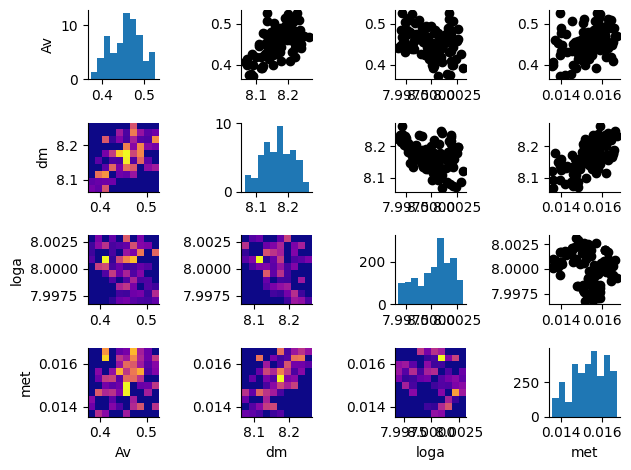

In [14]:
pyabc.settings.set_figure_params("pyabc")  # for beautified plots

# Matrix of 1d and 2d histograms over all parameters
pyabc.visualization.plot_histogram_matrix(history);

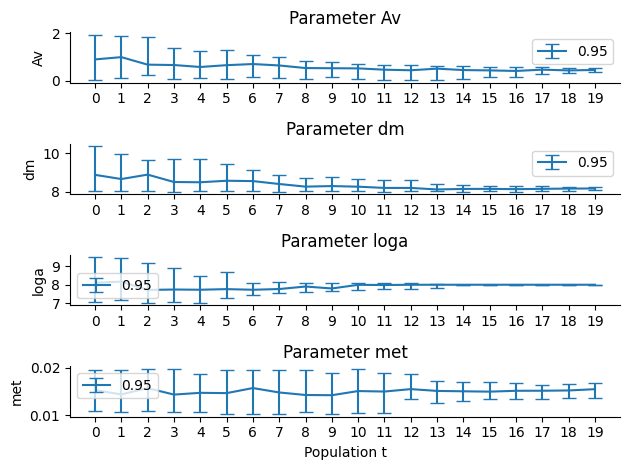

In [15]:
# Credible intervals over time
pyabc.visualization.plot_credible_intervals(history);

We can generate a CMD comparing our observed cluster with the "best fit" synthetic cluster found by pyABC. We start by updating the `fit_params` dictionary, which contains the median of the parameter distributions found by pyABC, to include those parameters that were not fitted and are stored in the `fixed_params` dictionary:

In [16]:
# Add `fixed_params` parameters to `fit_params`
fit_params.update(dict(fixed_params))

# Generate the "best fit" synthetic cluster using these parameters
synth_arr = synthcl.generate(fit_params)

and generate a side-by-side CMD plot showing also the theoretical isochrone associated to the "best fit" synthetic cluster:

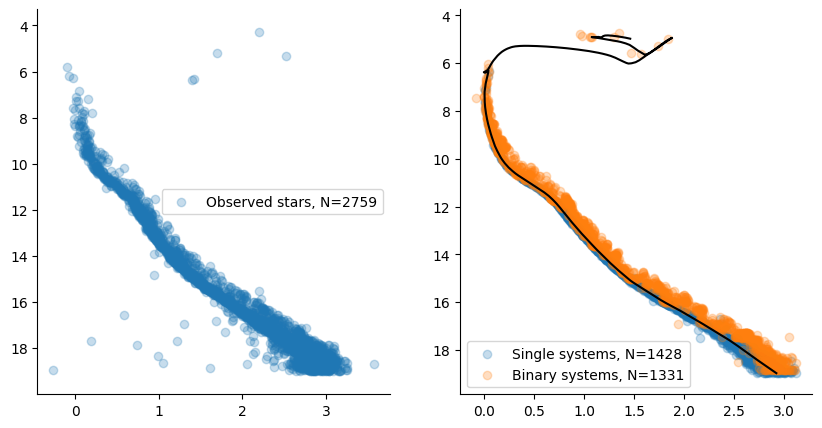

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def cmd_plot(color, mag, label, ax=None):
    """Function to generate a CMD plot"""
    if ax is None:
        ax = plt.subplot(111)
    label = label + f", N={len(mag)}"
    ax.scatter(color, mag, alpha=0.25, label=label)
    ax.legend()
    ax.set_ylim(mag.max() + 1, mag.min() - 1)  # Invert y axis

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Observed cluster
cmd_plot(my_cluster.color, my_cluster.mag, "Observed stars", ax1)

# Synthetic cluster
# Boolean mask identifying the binary systems
binary_msk = ~np.isnan(synth_arr[-1])
# Extract magnitude and color
mag, color = synth_arr[0], synth_arr[1]
# Plot single systems
cmd_plot(color[~binary_msk], mag[~binary_msk], "Single systems", ax2)
# Plot binary systems
cmd_plot(color[binary_msk], mag[binary_msk], "Binary systems", ax2)

# Get isochrone associated to the synthetic cluster
isoch_arr = synthcl.get_isochrone(fit_params)
# Plot the isochrone
plt.plot(isoch_arr[1], isoch_arr[0], c="k");